#### Medical Cost Data (Insurance)


- ge: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance


Data source at: [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download)



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [6]:
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Exploaratory Data Analysis

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
insurance.describe()
insurance.isna().sum()
insurance.isnull().count()

age         1338
sex         1338
bmi         1338
children    1338
smoker      1338
region      1338
charges     1338
dtype: int64

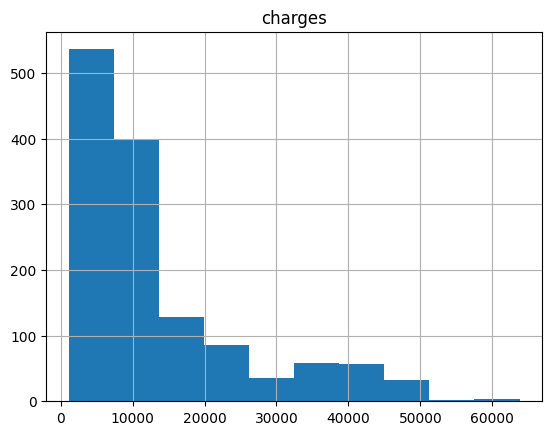

In [7]:
insurance.hist('charges')
plt.show()

##### we would now apply a base log (two) to help normalise the histogram above

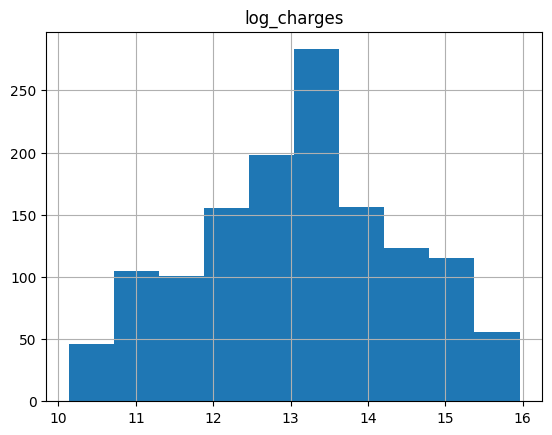

In [8]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")
plt.show()

In [11]:
correlations = insurance.corr(numeric_only=True)
correlations

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


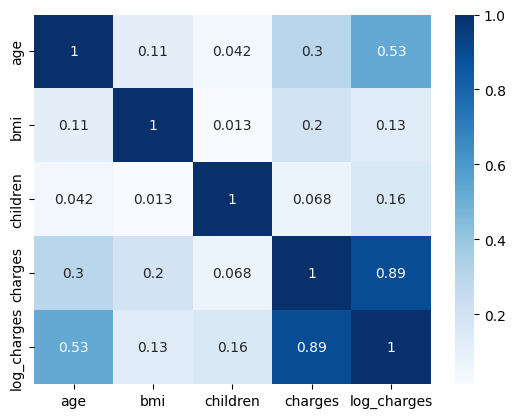

In [12]:
sns.heatmap(correlations, cmap='Blues', annot=True)
plt.show()

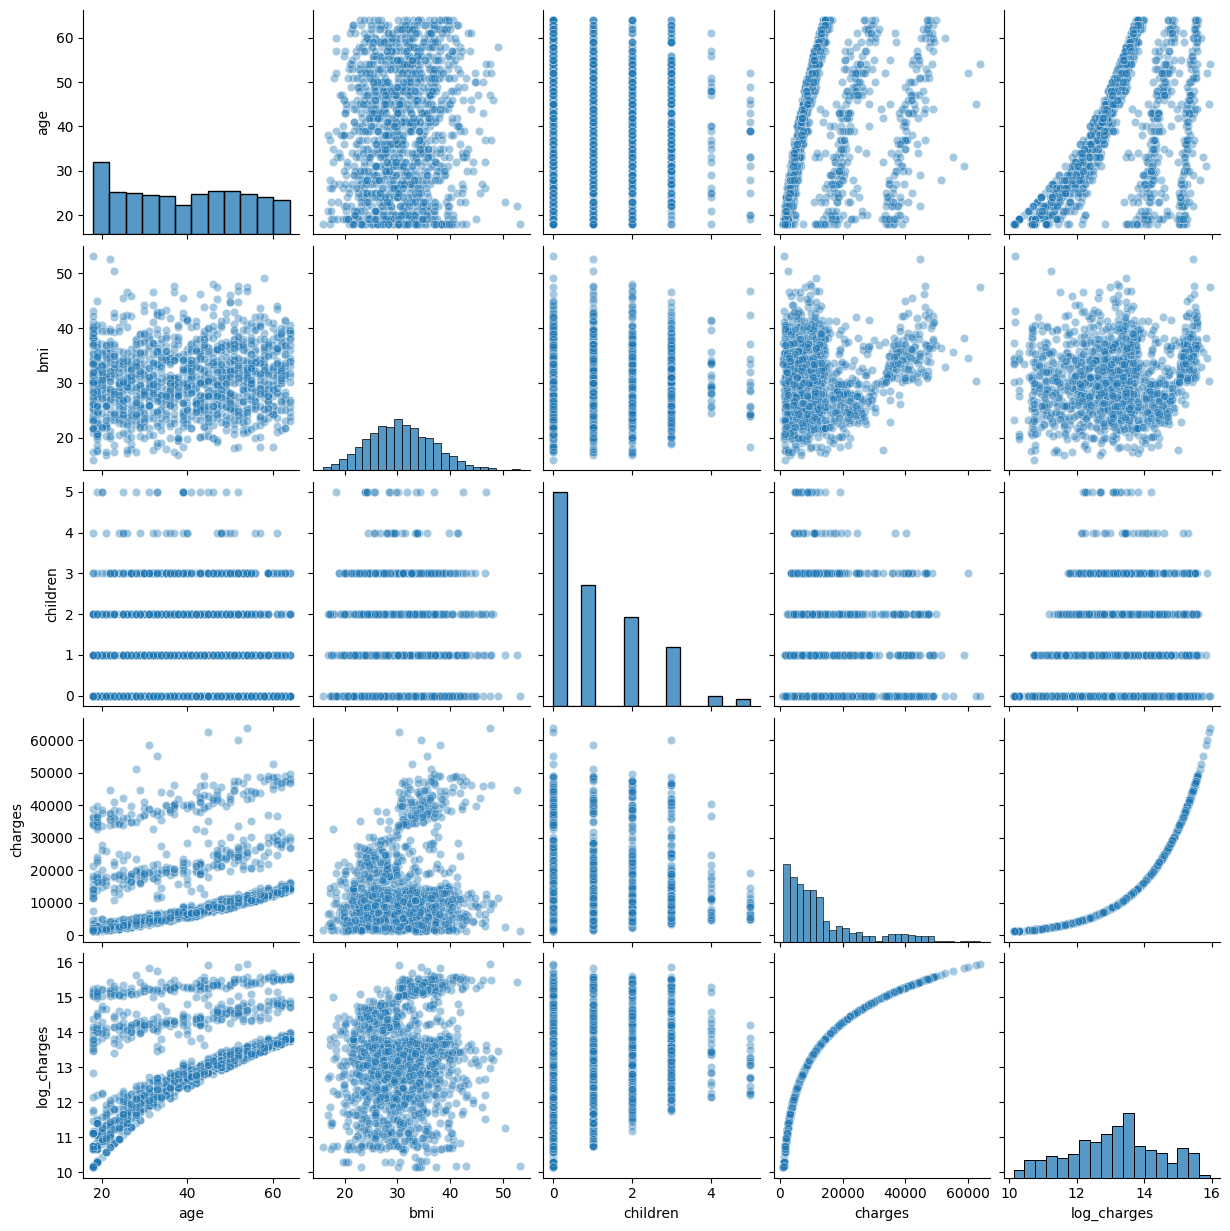

In [13]:
insurance_numeric = insurance[['age', 'bmi', 'children', 'charges', 'log_charges']]
sns.pairplot(insurance_numeric, kind='scatter', plot_kws={'alpha': 0.4})

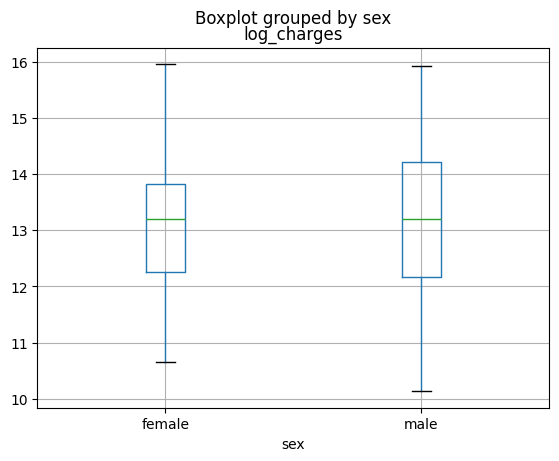

In [14]:
insurance.boxplot(column=["log_charges"], by="sex")
plt.show()

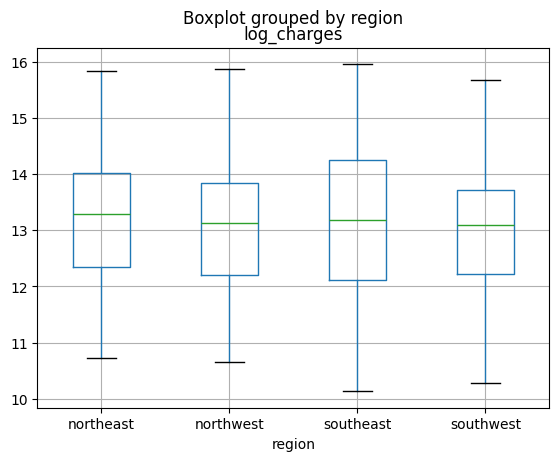

In [15]:
insurance.boxplot(column=["log_charges"], by="region")
plt.show()

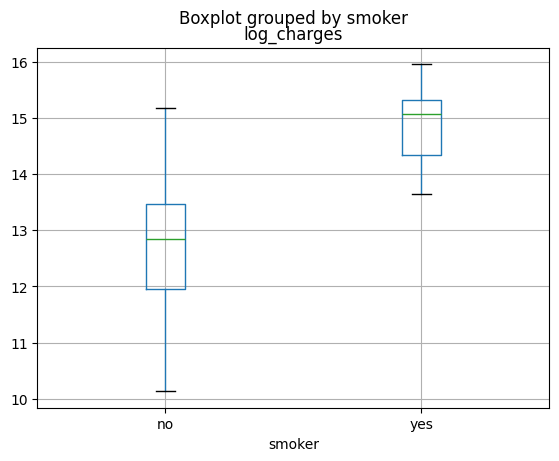

In [16]:
insurance.boxplot(column=["log_charges"], by="smoker")
plt.show()

### Feature Selection

#### splitting dataset (training and test data)

In [17]:
# Splitting the data up into a training and test set
insurance["is_smoker"] = (insurance["smoker"] == "yes")
# insurance["is_male"] = (insurance['sex'] == 'male')
# insurance['is_west'] = ((insurance['region'] == 'northwest') | (insurance['region'] == 'southwest'))
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)
insurance_model.coef_

array([0.0508618 , 0.01563733, 2.23214787])

In [20]:
y_pred = insurance_model.predict(X_train)
y_pred

array([11.79052705, 12.03861881, 13.41469648, ..., 13.54359685,
       15.05831411, 13.46489784])

In [21]:
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.447919196329921

In [22]:
# MSE on the original scale for the insurance charges
train_mse_orig_scale = np.exp2(mean_squared_error(y_train, y_pred))
train_mse_orig_scale

1.3640714326864816

In [23]:
train_r2 = r2_score(y_train, y_pred)
train_r2

0.743333600772825

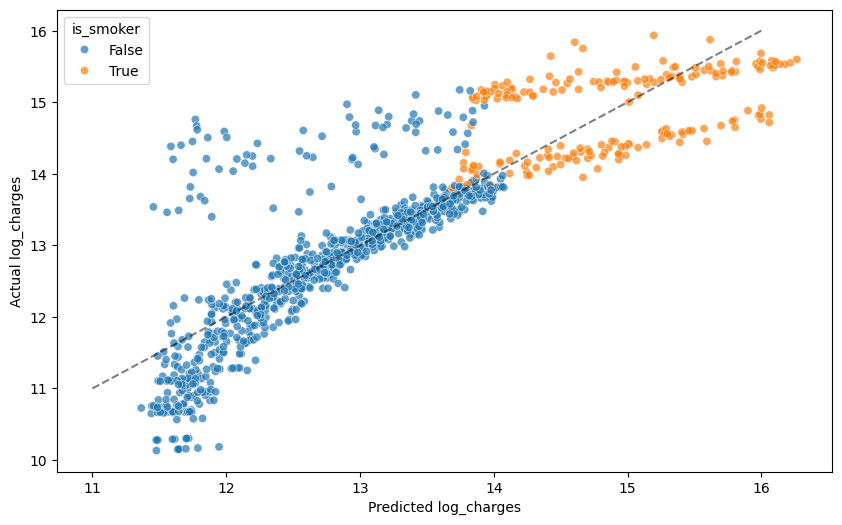

In [29]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'is_smoker': X_train['is_smoker'],
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Create scatter plot with hue for smoker status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', data=plot_df, alpha=0.7, hue='is_smoker')

#straight line
plt.plot([11, 16], [11, 16], 'k--', alpha=0.5)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

<Axes: xlabel='predictions', ylabel='residuals'>

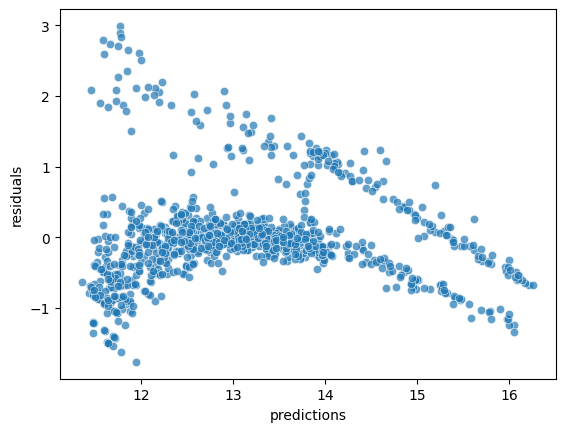

In [26]:
sns.scatterplot(x='predictions', y='residuals', data=plot_df, alpha=0.7)

the above show a violation of the Linear regression model, hence further investigation is needed

In [27]:
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4529281560931768

In [28]:
# Putting the outcome (in log-terms) back into the original scale
np.exp2(mean_squared_error(y_test, test_pred))

1.368815646563475

#### Analysing by smoker status
Now lets create a model for only smokers and evaluate


In [30]:
smokers_df = insurance[insurance["is_smoker"] == True]

In [31]:
X = smokers_df[["age", "bmi"]]
y = smokers_df["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
smoker_model = LinearRegression()
smoker_model.fit(X_train, y_train)
smoker_model.coef_

array([0.01282851, 0.07098738])

In [33]:
y_pred = smoker_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.07046354357369701

In [34]:
train_r2 = r2_score(y_train, y_pred)
train_r2


0.7661650418251629

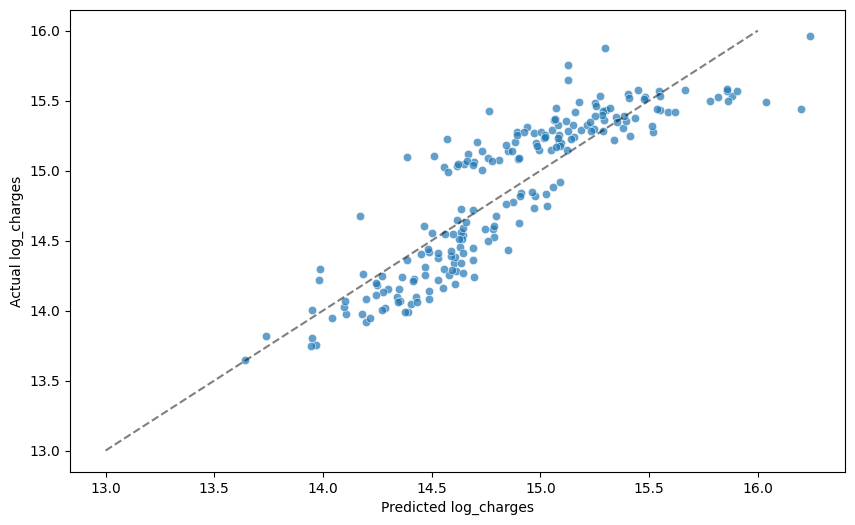

In [35]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Create scatter plot with hue for smoker status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', data=plot_df, alpha=0.7)

plt.plot([13, 16], [13, 16], 'k--', alpha=0.5)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

<Axes: xlabel='predictions', ylabel='residuals'>

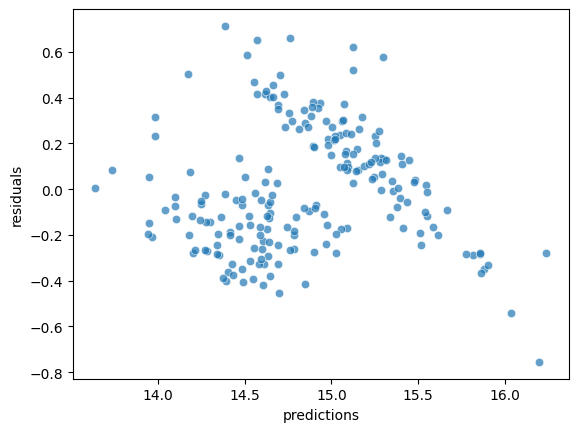

In [36]:
sns.scatterplot(x='predictions', y='residuals', data=plot_df, alpha=0.7)

NB: The above is better than the ealier results but still have some data issues with the residuals

In [37]:
test_pred = smoker_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.09416078156173806

the model is more predictive than the initial result of 0.45